The **preprocessing** steps (removing outliers and one-hot encoding categorical variables) have already been accomplished in the Random Forest Model Training so we'll just load in the cleaned dataset

In [1]:
# Making sure XGBoost is installed in the environment
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Load the preprocessed and cleaned dataset
data_filepath = '../data/processed/cleaned_diabetes_one_hot_encoding.csv'
df = pd.read_csv(data_filepath)
print("\nThese are the number of people with and without diabetes")
print(df['diabetes'].value_counts())


These are the number of people with and without diabetes
0    82605
1     6632
Name: diabetes, dtype: int64


In [3]:
print("This is the Data distribution of all variables in the dataset")
print(df.describe()) # Data distribution of variables

This is the Data distribution of all variables in the dataset
                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  89237.000000  89237.000000   89237.000000  89237.000000  89237.000000   
mean      41.665855      0.069086       0.037484     26.357026      5.511976   
std       22.777219      0.253601       0.189947      4.901841      1.060805   
min        0.080000      0.000000       0.000000     14.710000      3.500000   
25%       23.000000      0.000000       0.000000     23.420000      4.800000   
50%       42.000000      0.000000       0.000000     27.320000      5.800000   
75%       60.000000      0.000000       0.000000     28.350000      6.200000   
max       80.000000      1.000000       1.000000     38.500000      9.000000   

       blood_glucose_level      diabetes  gender_Female   gender_Male  \
count         89237.000000  89237.000000   89237.000000  89237.000000   
mean            137.445096      0.074319       0.580062      0.419759  

In [4]:
df.head()

age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  gender_Other  \
0         0              1            0             0   
1         0              1            0             0   
2         0              0            1             0   
3         0              1            0             0   
4         0              0            1             0   

   smoking_history_No Info  smoking_history_current  smoking_history_former  \
0                        0                        0                       0   
1                        1                        0                       0   
2                        0                        0                       0   
3                        0                        1                       0   
4                        0                        1                       0   

   smoking_history_never  smoking_history_not current  
0                      1                            0  
1                      0                            0  
2                      1                            0  
3                      0                            0  
4                      0                            0

## Model Building - Initial

In [5]:
# Separating the features (X) and the target variable (y)
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [6]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting the dataset into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
# Specifying the XGBoost model parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Evaluation metric
    'max_depth': 6,  # Depth of the trees
    'eta': 0.3,  # Learning rate
    'seed': 42  # Random seed for reproducibility
}
num_rounds = 100  # Number of boosting rounds

# Training the XGBoost model
bst = xgb.train(params, dtrain, num_rounds)

In [8]:
# Making predictions on the test set
y_pred_prob = bst.predict(dtest)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Thresholding to get binary predictions

In [9]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities to compute ROC AUC
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Displaying the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.972658000896459
ROC AUC: 0.9749866407052354
Confusion Matrix:
[[16467    38]
 [  450   893]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     16505
           1       0.96      0.66      0.79      1343

    accuracy                           0.97     17848
   macro avg       0.97      0.83      0.89     17848
weighted avg       0.97      0.97      0.97     17848



### Extensive Hyperparameter Tuning

In [10]:
'''from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# larger grid of hyperparameters to search
param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2)
}

# Randomized Search on hyper parameters
random_search = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42), 
                                   param_distributions=param_dist, n_iter=100, scoring='roc_auc', 
                                   n_jobs=-1, cv=5, verbose=3, random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and highest ROC AUC
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)'''

''' 
Best parameters identfied to avoid tuning again:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.9400154311159197, 'learning_rate': 0.09989013482764068, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 161, 'subsample': 0.7300733288106989}
Best ROC AUC Score: 0.9792405387270247
'''

" \nBest parameters identfied to avoid tuning again:\nFitting 5 folds for each of 100 candidates, totalling 500 fits\nBest Parameters: {'colsample_bytree': 0.9400154311159197, 'learning_rate': 0.09989013482764068, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 161, 'subsample': 0.7300733288106989}\nBest ROC AUC Score: 0.9792405387270247\n"

In [11]:
# Use the best parameters identified from the tuning process directly
optimized_model = xgb.XGBClassifier(
    colsample_bytree=0.9400154311159197,
    learning_rate=0.09989013482764068,
    max_depth=3,
    min_child_weight=7,
    n_estimators=161,
    subsample=0.7300733288106989,
    objective='binary:logistic',
    seed=42
)

optimized_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = optimized_model.predict(X_test)
y_pred_prob = optimized_model.predict_proba(X_test)[:, 1]

# Compute and print the evaluation metrics
accuracy_optimized = accuracy_score(y_test, y_pred)
roc_auc_optimized = roc_auc_score(y_test, y_pred_prob)
conf_matrix_optimized = confusion_matrix(y_test, y_pred)
class_report_optimized = classification_report(y_test, y_pred)

print(f"Optimized Model Accuracy: {accuracy_optimized}")
print(f"Optimized Model ROC AUC: {roc_auc_optimized}")
print("Optimized Model Confusion Matrix:")
print(conf_matrix_optimized)
print("Optimized Model Classification Report:")
print(class_report_optimized)


Optimized Model Accuracy: 0.9731622590766472
Optimized Model ROC AUC: 0.9776822069081258
Optimized Model Confusion Matrix:
[[16488    17]
 [  462   881]]
Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     16505
           1       0.98      0.66      0.79      1343

    accuracy                           0.97     17848
   macro avg       0.98      0.83      0.89     17848
weighted avg       0.97      0.97      0.97     17848



### Feature Engineering before balancing the Dataset

In [12]:
data_filepath = '../data/processed/cleaned_diabetes_with_feature_engineering.csv'
df_enhanced = pd.read_csv(data_filepath)

X_enhanced = df_enhanced.drop('diabetes', axis=1)
Y_enhanced = df_enhanced['diabetes']

# Splitting the data into training and testing sets
X_train_enhanced, X_test_enhanced, Y_train_enhanced, Y_test_enhanced = train_test_split(X_enhanced, Y_enhanced, test_size=0.2, random_state=42)

# Training the XGBoost Model with Enhanced Features
dtrain_enhanced = xgb.DMatrix(X_train_enhanced, label=Y_train_enhanced)
dtest_enhanced = xgb.DMatrix(X_test_enhanced, label=Y_test_enhanced)

# Reusing the optimized hyperparameters
params_optimized = {
    'colsample_bytree': 0.9400154311159197,
    'learning_rate': 0.09989013482764068,
    'max_depth': 3,
    'min_child_weight': 7,
    'n_estimators': 161,
    'subsample': 0.7300733288106989,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train the model
bst_enhanced = xgb.train(params_optimized, dtrain_enhanced, num_rounds)

# Evaluating the enhanced model
# Making predictions on the test set
y_pred_prob_enhanced = bst_enhanced.predict(dtest_enhanced)
y_pred_enhanced = np.where(y_pred_prob_enhanced > 0.5, 1, 0)

# Evaluation
accuracy_enhanced = accuracy_score(Y_test_enhanced, y_pred_enhanced)
roc_auc_enhanced = roc_auc_score(Y_test_enhanced, y_pred_prob_enhanced)
conf_matrix_enhanced = confusion_matrix(Y_test_enhanced, y_pred_enhanced)
class_report_enhanced = classification_report(Y_test_enhanced, y_pred_enhanced)

# Display the evaluation metrics
print(f"Enhanced Model with Feature Engineering Accuracy: {accuracy_enhanced}")
print(f"Enhanced Model with Feature Engineering ROC AUC: {roc_auc_enhanced}")
print("Enhanced Model with Feature Engineering Confusion Matrix:\n", conf_matrix_enhanced)
print("Enhanced Model with Feature Engineering Classification Report:\n", class_report_enhanced)

[15:20:31] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Enhanced Model with Feature Engineering Accuracy: 0.973722545943523
Enhanced Model with Feature Engineering ROC AUC: 0.9765010174267461
Enhanced Model with Feature Engineering Confusion Matrix:
 [[16502     3]
 [  466   877]]
Enhanced Model with Feature Engineering Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     16505
           1       1.00      0.65      0.79      1343

    accuracy                           0.97     17848
   macro avg       0.98      0.83      0.89     17848
weighted avg       0.97      0.97      0.97     17848



### Addressing Class Imbalance

In [13]:
from xgboost import XGBClassifier
# Calculate the scale_pos_weight value
# This is usually total_negative_examples / total_positive_examples
scale_pos_weight_value = Y_train_enhanced.value_counts()[0] / Y_train_enhanced.value_counts()[1]

# Initialize the XGBoost model with optimized parameters and scale_pos_weight
xgb_model = XGBClassifier(
    colsample_bytree=0.9400154311159197,
    learning_rate=0.09989013482764068,
    max_depth=3,
    min_child_weight=7,
    n_estimators=161,
    subsample=0.7300733288106989,
    objective='binary:logistic',
    eval_metric='logloss',
    seed=42,
    scale_pos_weight=scale_pos_weight_value
)

# Train the model
xgb_model.fit(X_train_enhanced, Y_train_enhanced)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_enhanced)
y_pred_prob = xgb_model.predict_proba(X_test_enhanced)[:, 1]

# Compute and print the evaluation metrics
accuracy_optimized = accuracy_score(Y_test_enhanced, y_pred)
roc_auc_optimized = roc_auc_score(Y_test_enhanced, y_pred_prob)
conf_matrix_optimized = confusion_matrix(Y_test_enhanced, y_pred)
class_report_optimized = classification_report(Y_test_enhanced, y_pred)

print(f"Optimized Model with Class Balancing Accuracy: {accuracy_optimized}")
print(f"Optimized Model with Class Balancing ROC AUC: {roc_auc_optimized}")
print("Optimized Model with Class Balancing Confusion Matrix:\n", conf_matrix_optimized)
print("Optimized Model with Class Balancing Classification Report:\n", class_report_optimized)

Optimized Model with Class Balancing Accuracy: 0.8998767368892873
Optimized Model with Class Balancing ROC AUC: 0.9778053898692222
Optimized Model with Class Balancing Confusion Matrix:
 [[14827  1678]
 [  109  1234]]
Optimized Model with Class Balancing Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     16505
           1       0.42      0.92      0.58      1343

    accuracy                           0.90     17848
   macro avg       0.71      0.91      0.76     17848
weighted avg       0.95      0.90      0.92     17848



#### Threshold Tuning

In [14]:
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_test_enhanced, y_pred_prob)

# Find threshold that maximizes F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply threshold to positive probabilities to create new predictions
y_pred_optimized = (y_pred_prob >= best_threshold).astype(int)

# Evaluate these new predictions
print("Optimized Model with Best Threshold Accuracy:", accuracy_score(Y_test_enhanced, y_pred_optimized))
print("Optimized Model with Best Threshold Confusion Matrix:\n", confusion_matrix(Y_test_enhanced, y_pred_optimized))
print("Optimized Model with Best Threshold Classification Report:\n", classification_report(Y_test_enhanced, y_pred_optimized))

Optimized Model with Best Threshold Accuracy: 0.9738906320035858
Optimized Model with Best Threshold Confusion Matrix:
 [[16504     1]
 [  465   878]]
Optimized Model with Best Threshold Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     16505
           1       1.00      0.65      0.79      1343

    accuracy                           0.97     17848
   macro avg       0.99      0.83      0.89     17848
weighted avg       0.97      0.97      0.97     17848



#### Cross Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming X and y are features and labels
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for train_index, test_index in kfold.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    model = xgb.XGBClassifier(
        colsample_bytree=0.9400154311159197,
        learning_rate=0.09989013482764068,
        max_depth=3,
        min_child_weight=7,
        n_estimators=161,
        subsample=0.7300733288106989,
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
    )
    
    model.fit(X_train_fold, y_train_fold)
    y_pred_prob = model.predict_proba(X_test_fold)[:, 1]
    roc_auc = roc_auc_score(y_test_fold, y_pred_prob)
    results.append(roc_auc)

print(f"Mean ROC AUC: {np.mean(results)}")

# Retrain the model on the entire training data using best hyperparameters
final_model = xgb.XGBClassifier(
    colsample_bytree=0.9400154311159197,
    learning_rate=0.09989013482764068,
    max_depth=3,
    min_child_weight=7,
    n_estimators=161,
    subsample=0.7300733288106989,
    objective='binary:logistic',
    eval_metric='logloss',
    seed=42
)

final_model.fit(X_train, y_train)

# Evaluate on a separate test set
y_pred_prob_final = final_model.predict_proba(X_test)[:, 1]
final_roc_auc = roc_auc_score(y_test, y_pred_prob_final)

print(f"Final Model ROC AUC on Test Set: {final_roc_auc}")

Mean ROC AUC: 0.9789041548210553
Final Model ROC AUC on Test Set: 0.9776822069081258


#### Baysian Optimization

In [16]:
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [17]:
'''

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'n_estimators': hp.choice('n_estimators', range(100, 500)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
}

def objective(space):
    model = xgb.XGBClassifier(
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate'],
        objective='binary:logistic',
        random_state=42
    )
    
    auc = cross_val_score(model, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best parameters:", best) '''

'''
100%|██████| 100/100 [31:16<00:00, 18.76s/trial, best loss: -0.9790003751509359]
Best parameters: {'colsample_bytree': 0.8647783037718892, 'learning_rate': 0.04840129264965742, 'max_depth': 1, 'min_child_weight': 1.0, 'n_estimators': 329, 'subsample': 0.9160065601766973}

'''

"\n100%|██████| 100/100 [31:16<00:00, 18.76s/trial, best loss: -0.9790003751509359]\nBest parameters: {'colsample_bytree': 0.8647783037718892, 'learning_rate': 0.04840129264965742, 'max_depth': 1, 'min_child_weight': 1.0, 'n_estimators': 329, 'subsample': 0.9160065601766973}\n\n"

In [19]:
best_params = {
    'colsample_bytree': 0.8647783037718892,
    'learning_rate': 0.04840129264965742,
    'max_depth': 1,
    'min_child_weight': 1.0,
    'n_estimators': 329,
    'subsample': 0.9160065601766973
}

# Initialize the model with Bayesian Optimization's best parameters
optimized_model_bo = xgb.XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    learning_rate=best_params['learning_rate'],
    max_depth=3 + best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective='binary:logistic',
    seed=42
)

# Train the model on the entire training dataset
optimized_model_bo.fit(X_train, y_train)

# Making predictions on the test set
y_pred_bo = optimized_model_bo.predict(X_test)
y_pred_prob_bo = optimized_model_bo.predict_proba(X_test)[:, 1]

# Compute and print the evaluation metrics
accuracy_optimized_bo = accuracy_score(y_test, y_pred_bo)
roc_auc_optimized_bo = roc_auc_score(y_test, y_pred_prob_bo)
conf_matrix_optimized_bo = confusion_matrix(y_test, y_pred_bo)
class_report_optimized_bo = classification_report(y_test, y_pred_bo)

# Display the evaluation metrics
print(f"Optimized Model with Bayesian Optimization Accuracy: {accuracy_optimized_bo}")
print(f"Optimized Model with Bayesian Optimization ROC AUC: {roc_auc_optimized_bo}")
print("Optimized Model with Bayesian Optimization Confusion Matrix:")
print(conf_matrix_optimized_bo)
print("Optimized Model with Bayesian Optimization Classification Report:")
print(class_report_optimized_bo)


Optimized Model with Bayesian Optimization Accuracy: 0.97333034513671
Optimized Model with Bayesian Optimization ROC AUC: 0.9776217545485325
Optimized Model with Bayesian Optimization Confusion Matrix:
[[16490    15]
 [  461   882]]
Optimized Model with Bayesian Optimization Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     16505
           1       0.98      0.66      0.79      1343

    accuracy                           0.97     17848
   macro avg       0.98      0.83      0.89     17848
weighted avg       0.97      0.97      0.97     17848



### Model Interpretability

In [20]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


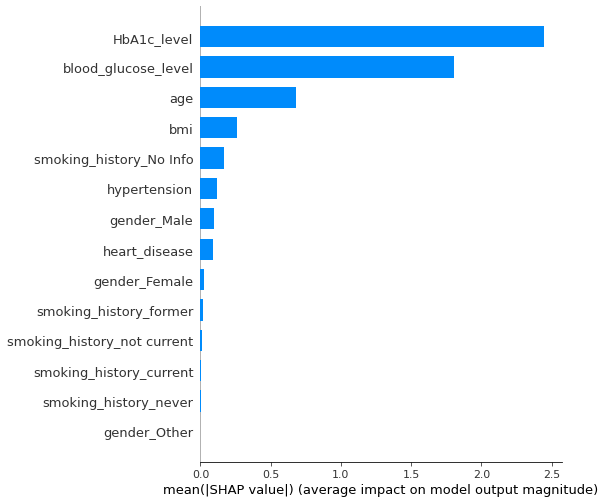

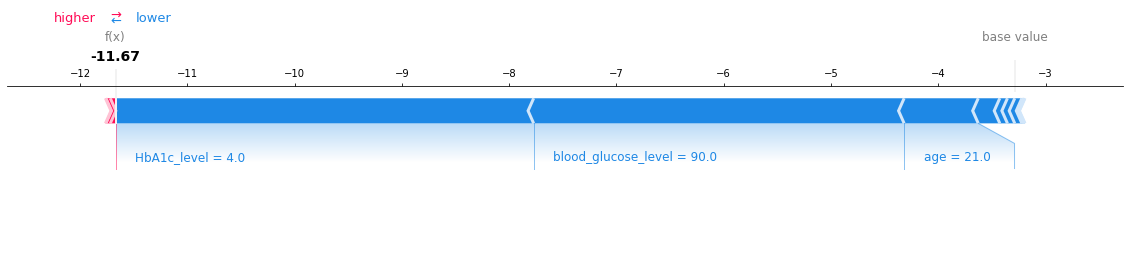

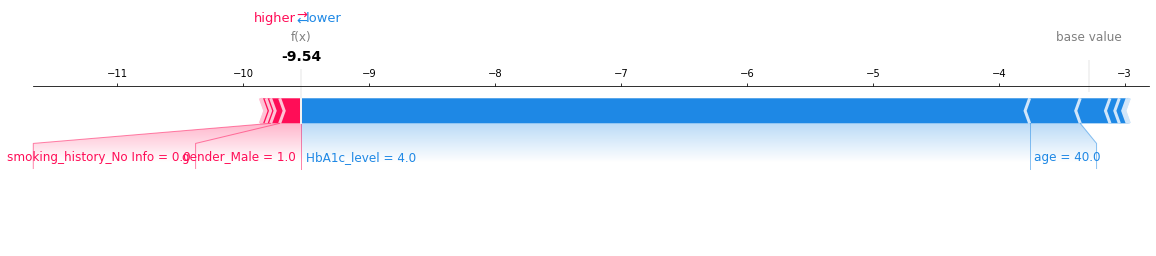

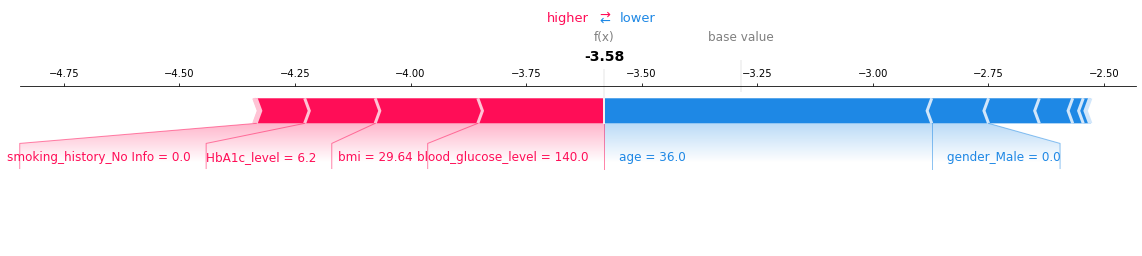

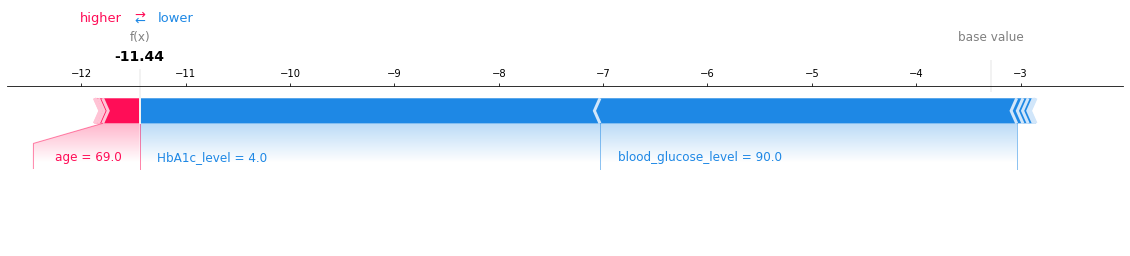

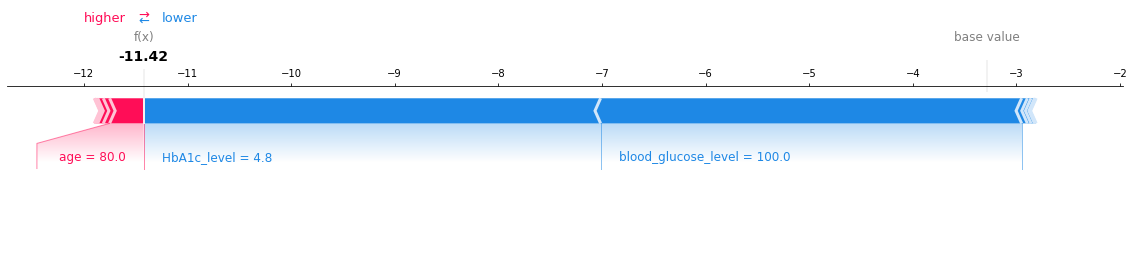

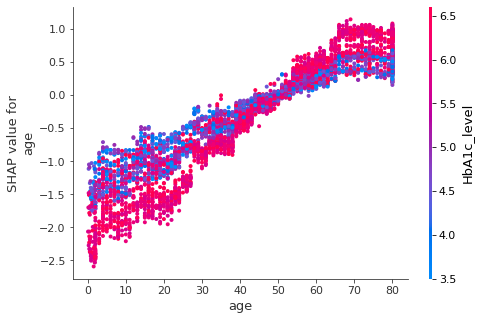

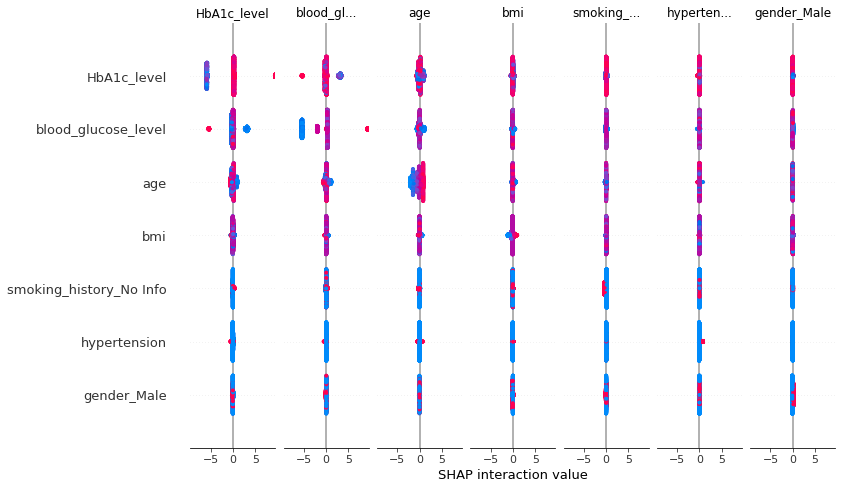

In [27]:
import shap

# Initialize a SHAP explainer object with the XGBoost model.
explainer = shap.TreeExplainer(optimized_model_bo)

# Compute SHAP values for a sample of the test set
sample_size = 5000
X_test_sample = X_test.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Visualize SHAP Values with summary plot
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

# For a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_sample.iloc[0])

# For multiple predictions
for i in range(5):
    shap.force_plot(explainer.expected_value, shap_values[i], X_test_sample.iloc[i], matplotlib=True)

# Dependence plot for a specific feature
shap.dependence_plot('age', shap_values, X_test_sample)

shap_interaction_values = explainer.shap_interaction_values(X_test_sample)
shap.summary_plot(shap_interaction_values, X_test_sample)


In [22]:
# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

#### Using LIME

In [23]:
!pip install lime

Defaulting to user installation because normal site-packages is not writeable


In [26]:
from lime import lime_tabular

# Initialize LIME Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Non-Diabetic', 'Diabetic'],
    mode='classification'
)

# Explain specific predictions from the test set
for idx in range(5):
    exp = explainer.explain_instance(
        data_row=X_test.iloc[idx].values,
        predict_fn=optimized_model_bo.predict_proba,
        num_features=10
    )
    exp.show_in_notebook(show_table=True, show_all=False)

#### Saving the Model

In [29]:
from joblib import dump

model_save_path = '../backend/DjangoDiabetesBackend/model/initialXGBoost.joblib'
dump(optimized_model_bo, model_save_path)

['../backend/DjangoDiabetesBackend/model/initialXGBoost.joblib']